In [1]:
import ee
# authentication
service_account =''
credentials = ee.ServiceAccountCredentials(service_account, "")
ee.Initialize(credentials)

In [2]:
import folium
import geemap
import os
import IPython.display as disp
from IPython.display import Image
import glob

In [3]:
# !pip install rasterio
import rasterio #for reading images
from skimage.transform import resize

In [4]:
from sklearn import cluster
from sklearn.metrics import silhouette_score
from skimage import data
from skimage.filters import try_all_threshold
from skimage.filters import threshold_minimum
from scipy import interpolate
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime

In [5]:
import sys

sys.path.append('../src/data/')

from make_dataset import exportData, computeMNDWI, readData, computeNDWI
from etl import computeNDWI

Use this website to generate new JSON structures: https://geojson.io/#new&map=10.57/39.6198/-121.4357

In [7]:
# determine area of interest
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -121.57931418110947,
              39.73107014130147
            ],
            [
              -121.57931418110947,
              39.524185236048766
            ],
            [
              -121.28277910072802,
              39.524185236048766
            ],
            [
              -121.28277910072802,
              39.73107014130147
            ],
            [
              -121.57931418110947,
              39.73107014130147
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [8]:
# grab the coordinates for area of interest
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

# define start and end dates for data 
start_date = '2013-03-18'
end_date = '2022-10-24'

#### Now we will start using GEE API to gatther data on various satellites

In [ ]:
# import Landsat 8 Level 2, Collection 2, Tier 1 surface reflectance
images_sr = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterDate(start_date, end_date).filterBounds(aoi)
# filter cloudy images, threshold of 50 percent
images_sr = images_sr.filter(ee.Filter.lte('CLOUD_COVER', 0.50))

In [ ]:
# sentinel image data
images_sentinel = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(start_date, end_date).filterBounds(aoi)
images_setinel = images_sentinel.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 0.20))

In [ ]:
# Landsat 7 Level 2, Collection 2, Tier 1 surface reflectance
images_landsat7 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterDate(start_date, end_date).filterBounds(aoi)
images_landsat7 = images_landsat7.filter(ee.Filter.lte('CLOUD_COVER', 0.80))

In [ ]:
# MOD44W.006 Terra Land Water Mask Derived From MODIS and SRTM Yearly Global 250m
modis_water_mask = ee.ImageCollection("MODIS/006/MOD44W").filterDate(start_date, end_date).filterBounds(aoi)

In [ ]:
# JRC Monthly Water History, v1.4
images_validation = ee.ImageCollection("JRC/GSW1_4/MonthlyHistory").filterDate(start_date, end_date).filterBounds(aoi)

### Export Image Collection Section Using geemap

##### Export landsat 7 image data

In [ ]:
landsat7 = images_landsat7.map(computeNDWI).select("NDWI")
collection_list = landsat7.toList(landsat7.size())
collection_size = collection_list.size().getInfo()
# # has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(landsat7, date_format='YYYY-MM-dd').getInfo()

In [ ]:
# --- Uncomment to start downloading locally ---
# exportData(
#     aoi,
#     dates, 
#     collection_size, 
#     collection_list, 
#     "../data/LANDSAT7_NDWI/LANDSAT7_NDWI_{}.tif"
# )

##### Export modis water mask image data

In [ ]:
modis = modis_water_mask.select("water_mask")
collection_list = modis.toList(modis.size())
collection_size = collection_list.size().getInfo()
# # has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(modis, date_format='YYYY-MM-dd').getInfo()

In [ ]:
# --- Uncomment to start downloading locally ---
# exportData(
#     aoi,
#     dates, 
#     collection_size, 
#     collection_list, 
#     "../data/WATER_MASK_DERIVED_MODIS/MODIS_WATER_MASK_{}.tif"
# )

##### Export setinel image data

In [ ]:
setinel = images_setinel.map(computeNDWI).select("NDWI")
collection_list = setinel.toList(setinel.size())
collection_size = collection_list.size().getInfo()
# # has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(setinel, date_format='YYYY-MM-dd').getInfo()

In [ ]:
# --- Uncomment to start downloading locally ---
# exportData(
#     aoi,
#     dates, 
#     collection_size, 
#     collection_list, 
#     "../data/SENTINEL2_NDWI/SENTINEL2_NDWI_{}.tif"
# )

#### Band 3 Landsat 8

In [ ]:
# SR_B3 band
sr_b3 = images_sr.select('SR_B3')
collection_list = sr_b3.toList(sr_b3.size())
collection_size = collection_list.size().getInfo()
# has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(sr_b3, date_format='YYYY-MM-dd').getInfo()

In [ ]:
# --- Uncomment to start downloading locally ---
# exportData(
#     aoi,
#     dates, 
#     collection_size, 
#     collection_list, 
#     "../data/images/LANDSAT8_SR_B3/LANDSAT8_SR_B3_{}.tif"
# )

#### Band 5 Landsat 8

In [ ]:
# SR_B5 band
sr_b5 = images_sr.select('SR_B5')
collection_list = sr_b5.toList(sr_b5.size())
collection_size = collection_list.size().getInfo()
# has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(sr_b5, date_format='YYYY-MM-dd').getInfo()

In [ ]:
# --- Uncomment to start downloading locally ---
# exportData(
#     aoi,
#     dates, 
#     collection_size, 
#     collection_list, 
#     "../data/images/LANDSAT8_SR_B5/LANDSAT8_SR_B5_{}.tif"
# )

#### Band 6 Landsat 8

In [ ]:
# SR_B6 band
sr_b6 = images_sr.select('SR_B6')
collection_list = sr_b6.toList(sr_b6.size())
collection_size = collection_list.size().getInfo()
# has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(sr_b6, date_format='YYYY-MM-dd').getInfo()

In [ ]:
# --- Uncomment to start downloading locally ---
# exportData(
#     aoi,
#     dates, 
#     collection_size, 
#     collection_list, 
#     "../data/LANDSAT8_SR_B6/LANDSAT8_SR_B6_{}.tif"
# )

#### Band 7 Landsat 8

In [ ]:
# SR_B7 band
sr_b7 = images_sr.select('SR_B6')
collection_list = sr_b7.toList(sr_b7.size())
collection_size = collection_list.size().getInfo()
# has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(sr_b7, date_format='YYYY-MM-dd').getInfo()

In [ ]:
# --- Uncomment to start downloading locally ---
# exportData(
#     aoi,
#     dates, 
#     collection_size, 
#     collection_list, 
#     "../data/LANDSAT8_SR_B7/LANDSAT8_SR_B7_{}.tif"
# )

#### Landsat 8 NDWI images

In [ ]:
# ndwi
ndwi_images = images_sr.map(computeNDWI).select("NDWI")
collection_list = ndwi_images.toList(ndwi_images.size())
collection_size = collection_list.size().getInfo()
# has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(ndwi_images, date_format='YYYY-MM-dd').getInfo()

In [ ]:
# --- Uncomment to start downloading locally ---
# exportData(
#     aoi,
#     dates, 
#     collection_size, 
#     collection_list, 
#     "../data/LANDSAT8_NDWI_SR_B7/LANDSAT8_NDWI_B7_{}.tif"
# )

#### JRC Monthly Water History - will be used to compare our results

In [ ]:
# water band from JRC Monthly Water History
img_validation = images_validation.select("water")
collection_list = img_validation.toList(img_validation.size())
collection_size = collection_list.size().getInfo()
# has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(img_validation, date_format='YYYY-MM-dd').getInfo()

In [ ]:
# --- Uncomment to start downloading locally ---
# exportData(
#     aoi,
#     dates, 
#     collection_size, 
#     collection_list, 
#     "../data/JRC_Monthly_Water_History/JRC_Monthly_{}.tif"
# )

### Read Data Section
Make a list of all gathered images in the form of (date, image) tuples.

In [9]:
modis = readData("../data/WATER_MASK_DERIVED_MODIS/")
print(modis[0][0])
print(modis[0][1].shape)

2014-01-01
(768, 1884)


In [10]:
ndwi_sentinel = readData("../data/SENTINEL2_NDWI/")
print(ndwi_sentinel[0][0])
print(ndwi_sentinel[0][1].shape)

2019-05-05
(781, 863)


In [11]:
b3_img_lst = readData("../data/LANDSAT8_SR_B3/")
print(b3_img_lst[0][0])
print(b3_img_lst[0][1].shape)

2013-06-03
(781, 863)


In [12]:
b5_img_lst = readData("../data/LANDSAT8_SR_B5/")
print(b5_img_lst[0][0])
print(b5_img_lst[0][1].shape)

2013-06-03
(781, 863)


In [13]:
b6_img_lst = readData("../data/LANDSAT8_SR_B6/")
print(b6_img_lst[0][0])
print(b6_img_lst[0][1].shape)

2013-06-03
(781, 863)


In [14]:
b7_img_lst = readData("../data/LANDSAT8_SR_B7/")
print(b7_img_lst[0][0])
print(b7_img_lst[0][1].shape)

2013-06-03
(781, 863)


In [15]:
landsat8_ndwi_b5 = readData("../data/LANDSAT8_NDWI/")
print(landsat8_ndwi_b5[0][0])
print(landsat8_ndwi_b5[0][1].shape)

2013-06-03
(781, 863)


In [16]:
landsat8_ndwi_b6 = readData("../data/LANDSAT8_NDWI_SR_B6/")
print(landsat8_ndwi_b6[0][0])
print(landsat8_ndwi_b6[0][1].shape)

2013-06-03
(781, 863)


In [17]:
landsat8_ndwi_b7 = readData("../data/LANDSAT8_NDWI_SR_B7/")
print(landsat8_ndwi_b7[0][0])
print(landsat8_ndwi_b7[0][1].shape)

2013-06-03
(781, 863)


In [18]:
jrc_monthly_water_history = readData("../data/JRC_Monthly_Water_History/")
print(jrc_monthly_water_history[0][0])
print(jrc_monthly_water_history[0][1].shape)

2013-04-01
(769, 1102)


### Data Viz Section

#### NDWI image using sentinel data

2019-05-05


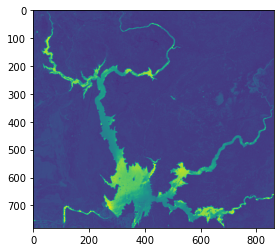

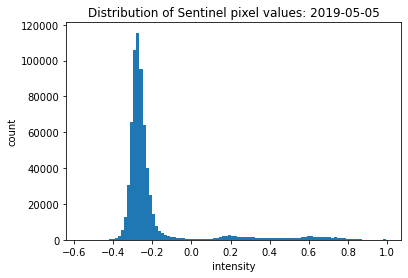

In [19]:
print(ndwi_sentinel[0][0])
plt.imshow(ndwi_sentinel[1][1])
plt.show()

plt.hist(
    ndwi_sentinel[1][1].flatten(), 
    bins=100
)
plt.ylabel("count")
plt.xlabel("intensity")
plt.title("Distribution of Sentinel pixel values: {}".format(ndwi_sentinel[0][0]))
plt.show()

#### As we can see, this image contains missing data. The lower left corner is cut off and the distribution of pixel values show some values in the image are 0.

2013-06-03


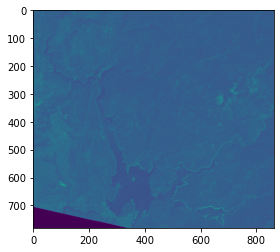

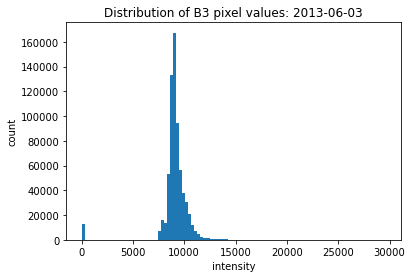

In [42]:
print(b3_img_lst[0][0])
plt.imshow(b3_img_lst[0][1])
plt.show()

plt.hist(
    b3_img_lst[0][1].flatten(), 
    bins=100
)
plt.ylabel("count")
plt.xlabel("intensity")
plt.title("Distribution of B3 pixel values: {}".format(b3_img_lst[0][0]))
plt.show()

#### Here we get a sense of what some of the distributions look like for each band.

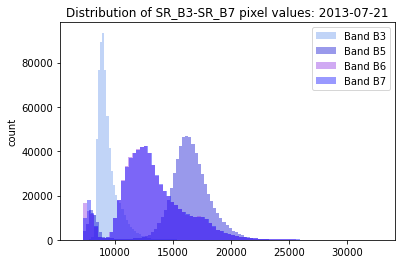

In [31]:
plt.hist(
    b3_img_lst[2][1].flatten(), 
    bins=80,
    alpha=0.4,
    label="Band B3",
    color="cornflowerblue"
)
plt.hist(
    b5_img_lst[2][1].flatten(), 
    bins=80,
    alpha=0.4,
    label="Band B5",
    color="mediumblue"
)
plt.hist(
    b6_img_lst[2][1].flatten(), 
    bins=80,
    alpha=0.4,
    label="Band B6",
    color="blueviolet"
)
plt.hist(
    b7_img_lst[2][1].flatten(), 
    bins=80,
    alpha=0.4,
    label="Band B7",
    color="blue"
)
plt.legend()
plt.ylabel("count")
plt.title("Distribution of SR_B3-SR_B7 pixel values: {}".format(b5_img_lst[2][0]))
plt.show()

#### Lets now compare B3 with all other bands.

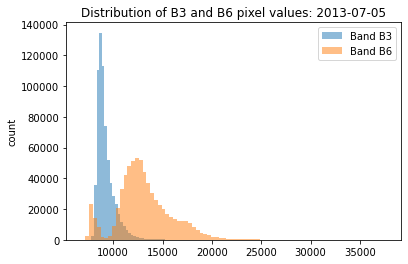

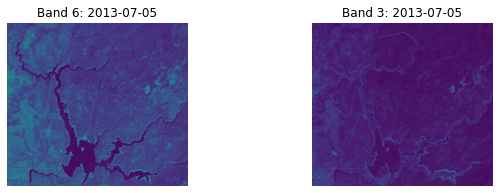

<Figure size 432x288 with 0 Axes>

In [30]:
plt.hist(
    b3_img_lst[1][1].flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B3"
)
plt.hist(
    b6_img_lst[1][1].flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B6"
)
plt.legend()
plt.ylabel("count")
plt.title("Distribution of B3 and B6 pixel values: {}".format(b6_img_lst[1][0]))
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
ax = axes.ravel()

ax[0].imshow(b6_img_lst[1][1])
ax[0].set_title('Band 6: {}'.format(b6_img_lst[1][0]))

ax[1].imshow(b3_img_lst[1][1])
ax[1].set_title('Band 3: {}'.format(b3_img_lst[1][0]))


for a in ax:
    a.axis('off')

plt.show()
plt.savefig(fname="savedfigs")

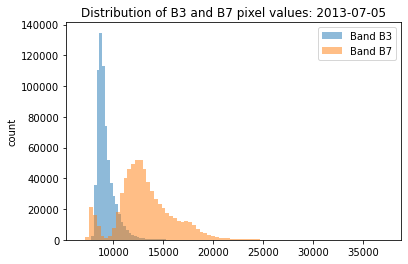

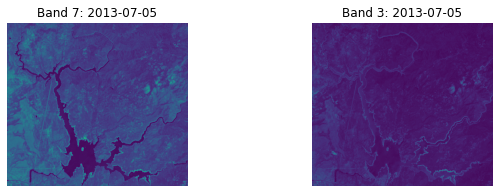

In [26]:
plt.hist(
    b3_img_lst[1][1].flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B3"
)
plt.hist(
    b7_img_lst[1][1].flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B7"
)
plt.legend()
plt.ylabel("count")
plt.title("Distribution of B3 and B7 pixel values: {}".format(b7_img_lst[1][0]))
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
ax = axes.ravel()

ax[0].imshow(b7_img_lst[1][1])
ax[0].set_title('Band 7: {}'.format(b7_img_lst[1][0]))

ax[1].imshow(b3_img_lst[1][1])
ax[1].set_title('Band 3: {}'.format(b3_img_lst[1][0]))


for a in ax:
    a.axis('off')

plt.show()

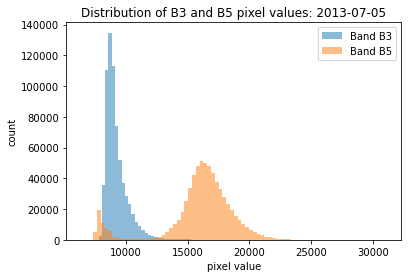

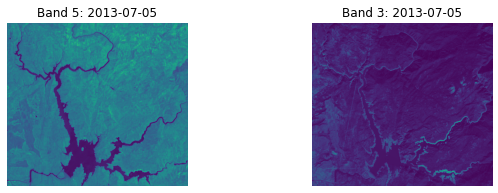

In [19]:
plt.hist(
    b3_img_lst[1][1].flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B3"
)
plt.hist(
    b5_img_lst[1][1].flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B5"
)

plt.legend()
plt.ylabel("count")
plt.title("Distribution of B3 and B5 pixel values: {}".format(b5_img_lst[1][0]))
plt.xlabel("pixel value")
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
ax = axes.ravel()

ax[0].imshow(b5_img_lst[1][1])
ax[0].set_title('Band 5: {}'.format(b5_img_lst[1][0]))

ax[1].imshow(b3_img_lst[6][1])
ax[1].set_title('Band 3: {}'.format(b3_img_lst[1][0]))


for a in ax:
    a.axis('off')
    
plt.show()

#### We also need to get a sense of what the average of all images will look like. 

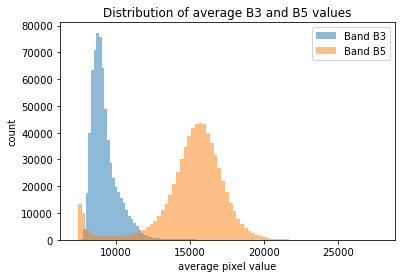

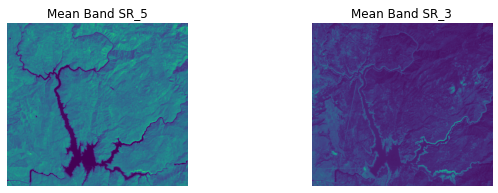

In [20]:
b3_mean_per_pixel = []
b5_mean_per_pixel = []
for i in range(1, len(b3_img_lst)):
    b3_mean_per_pixel.append(b3_img_lst[i][1])
    b5_mean_per_pixel.append(b5_img_lst[i][1])

b3_mean_per_pixel  = np.mean(
        np.dstack(b3_mean_per_pixel), 
        -1
    )
b5_mean_per_pixel  = np.mean(
        np.dstack(b5_mean_per_pixel), 
        -1
    )

plt.hist(
    b3_mean_per_pixel.flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B3"
)
plt.hist(
    b5_mean_per_pixel.flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B5"
)
plt.title("Distribution of average B3 and B5 values")
plt.legend()
plt.ylabel("count")
plt.xlabel("average pixel value")
plt.show()


fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
ax = axes.ravel()

ax[0].imshow(b5_mean_per_pixel)
ax[0].set_title('Mean Band SR_5')

ax[1].imshow(b3_mean_per_pixel)
ax[1].set_title('Mean Band SR_3')


for a in ax:
    a.axis('off')

plt.show()

#### Here we can see the difference in shape between the images (ndwi b3/b5 and our validation data). We must fix this issue before being able to come our estimated areas.

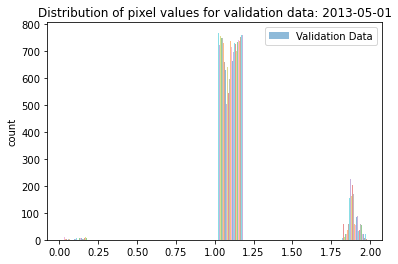

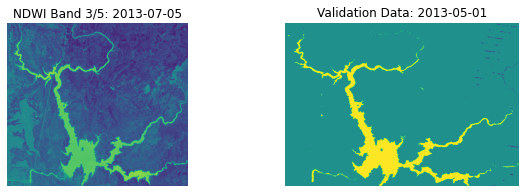

In [33]:
plt.hist(
    jrc_monthly_water_history[1][1], 
    alpha=0.5,
    label="Validation Data"
)
plt.legend()
plt.ylabel("count")
plt.title("Distribution of pixel values for validation data: {}".format(jrc_monthly_water_history[1][0]))
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
ax = axes.ravel()

ax[0].imshow(landsat8_ndwi_b5[1][1])
ax[0].set_title('NDWI Band 3/5: {}'.format(landsat8_ndwi_b5[1][0]))

ax[1].imshow(jrc_monthly_water_history[1][1])
ax[1].set_title('Validation Data: {}'.format(jrc_monthly_water_history[1][0]))


for a in ax:
    a.axis('off')

plt.show()

#### Some helper functions that aid us in reducing code later. These will help us in displaying and computing the surface area.

In [22]:
def visualize_images(img_lst, est_area_lst, binary):
    
    
    for i in range(len(img_lst)):

        fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
        ax = axes.ravel()

        ax[0].imshow(img_lst[i][1])
        ax[0].set_title('NDWI Image: {}'.format(img_lst[i][0]))

        ax[1].imshow(binary[i])
        ax[1].set_title(
            'Binary Image: {}'.format(img_lst[i][0])
        )
        for a in ax:
            a.axis('off')

        plt.show()
    

In [23]:
def estimate_surface_area(img_lst):
    
    out_list = []
    binary_out_lst = []

    for d, i in img_lst:
        thresh = threshold_minimum(i)
        binary = i > thresh
        binary_out_lst.append(binary)

        estimated_surface_area = (binary.flatten().sum() * (30 ** 2))
        out_list += [(d, estimated_surface_area)]
    
    return out_list, binary_out_lst

#### Call the functions above and save them in data structures to conduct the analysis

In [25]:
landsat8_ndwi_b5_est_area, binary_b5 = estimate_surface_area(landsat8_ndwi_b5)


# displays viz of images and estimated surface area
# --- uncomment to visualize ---
# visualize_images(
#     landsat8_ndwi_b5,
#     landsat8_ndwi_b5_est_area,
#     binary_b5
# )

In [26]:
landsat8_ndwi_b6_est_area, binary_b6 = estimate_surface_area(landsat8_ndwi_b6)


# displays viz of images and estimated surface area
# --- uncomment to visualize ---
# visualize_images(
#     landsat8_ndwi_b6,
#     landsat8_ndwi_b6_est_area,
#     binary_b6
# )

In [27]:
landsat8_ndwi_b7_est_area, binary_b7 = estimate_surface_area(landsat8_ndwi_b7)


# displays viz of images and estimated surface area
# --- uncomment to visualize ---
# visualize_images(
#     landsat8_ndwi_b7,
#     landsat8_ndwi_b7_est_area,
#     binary_b7
# )

#### Before we can begin to convert our validation data into binary images, we must resize the dimensions our the validation data. Below we demonstrate how exactly this is done, and show the resized image itself. 

In [28]:
# this will resize the validation image data to match the same dimensions of our landsat data
resized_jrc = []

for d, i in jrc_monthly_water_history:
    resized_jrc.append((d, resize(i, landsat8_ndwi_b5[0][1].shape)))

(781, 863)


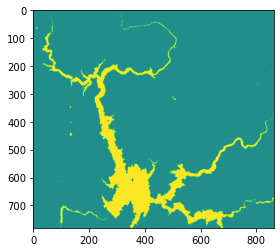

In [29]:
print(resized_jrc[0][1].shape)
plt.imshow(resized_jrc[0][1])

#### As we can see, the histogram shows good separation between water and non-water features. Using a threshold of 0.007 we are able to create a binary image with great separation between such features as well.

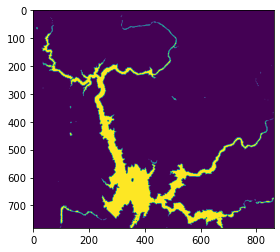

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 2., 3., 6.],
        [0., 0., 0., ..., 6., 3., 3.],
        [0., 0., 2., ..., 0., 1., 3.]]),
 array([6.90088643e-15, 7.84313725e-04, 1.56862745e-03, 2.35294118e-03,
        3.13725490e-03, 3.92156863e-03, 4.70588235e-03, 5.49019608e-03,
        6.27450980e-03, 7.05882353e-03, 7.84313725e-03]),
 <a list of 863 BarContainer objects>)

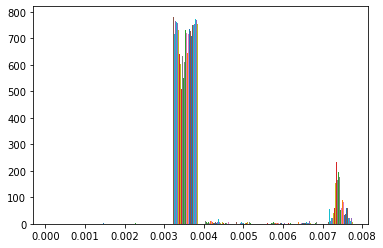

In [31]:
plt.imshow(resized_jrc[0][1] > 0.007)
plt.show()
plt.hist(
    resized_jrc[0][1]
)

#### Lets now convert all of our validation data into binary images. 

In [30]:
# create binary images using resized_jrc satellite images by using a threshold of 0.007
resized_jrc_binary = []

for d, i in resized_jrc:
    
    resized_jrc_binary.append((d, i > 0.007))

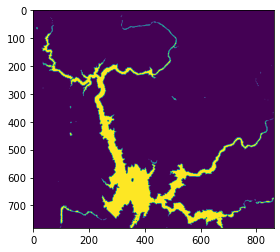

In [31]:
plt.imshow(resized_jrc_binary[0][1])

#### Taking a closer look at the dates associated with each image we see that the dates do not align very well. Therefore, additional processing is needed. 

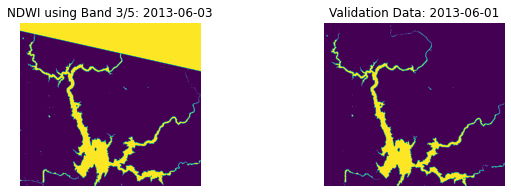

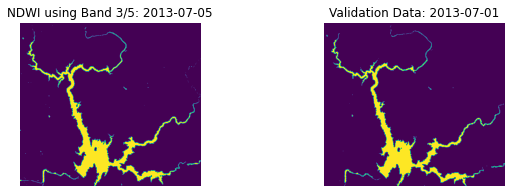

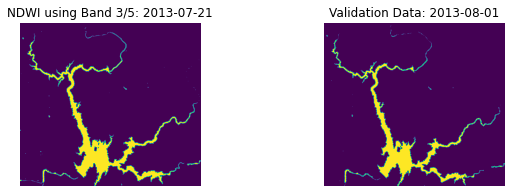

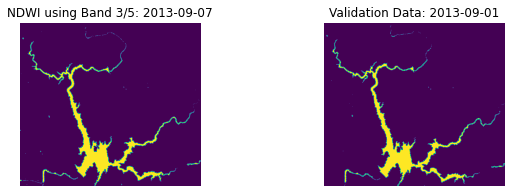

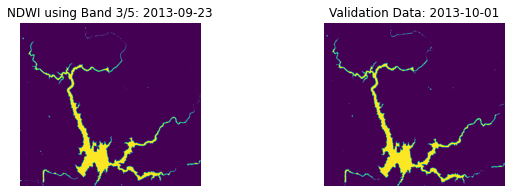

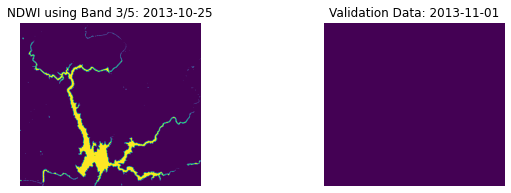

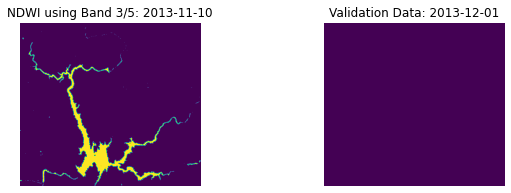

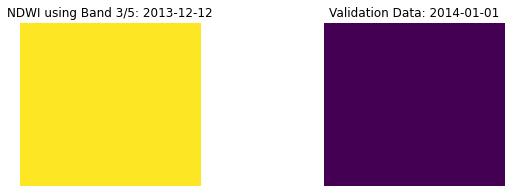

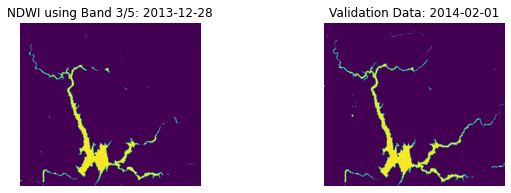

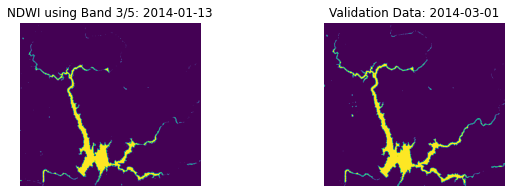

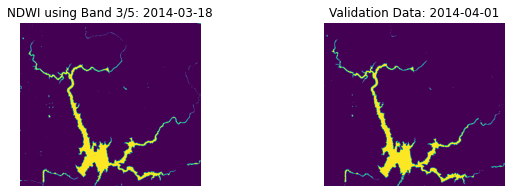

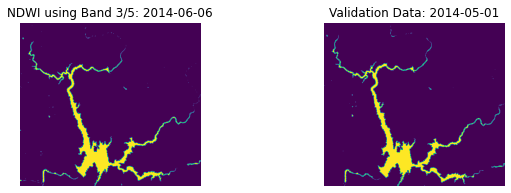

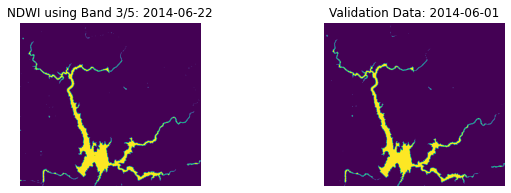

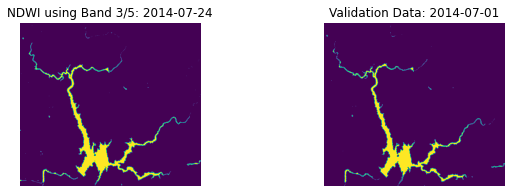

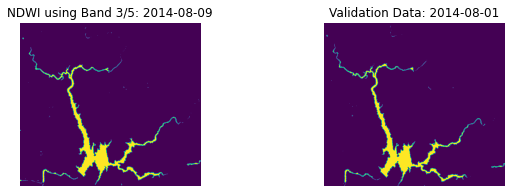

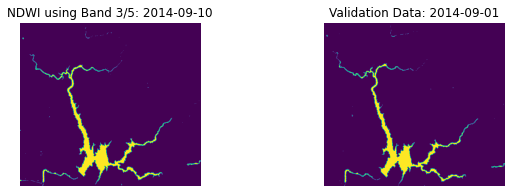

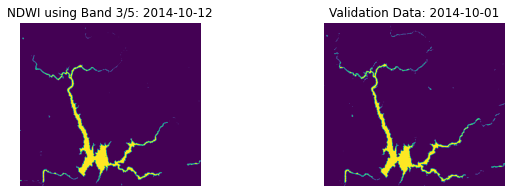

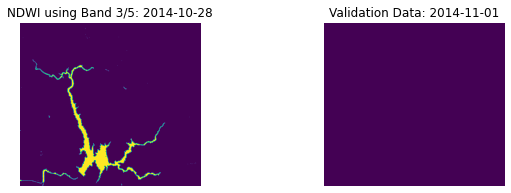

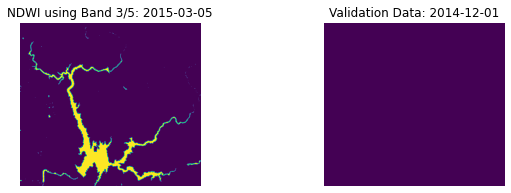

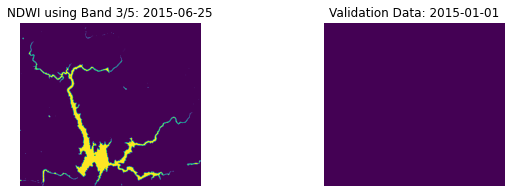

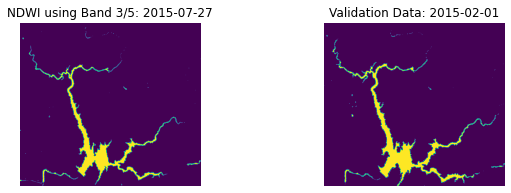

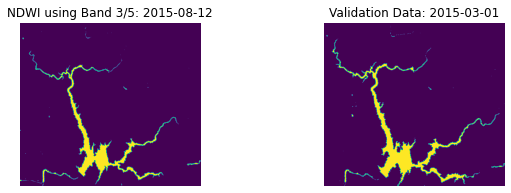

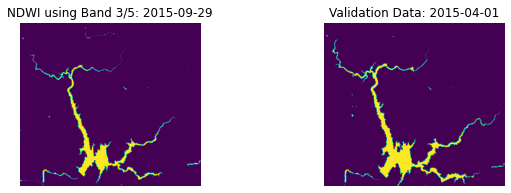

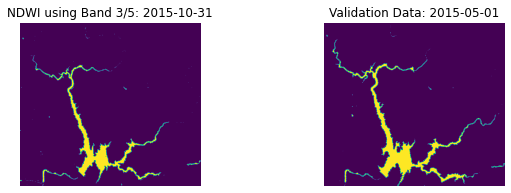

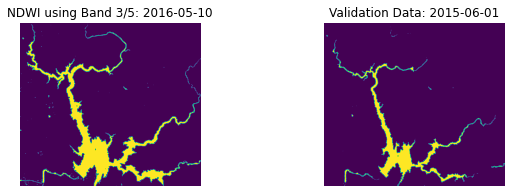

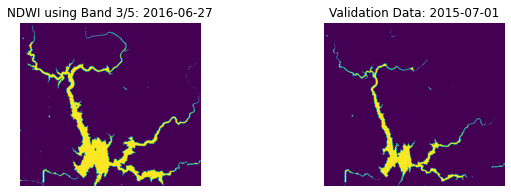

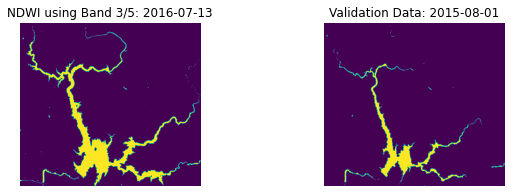

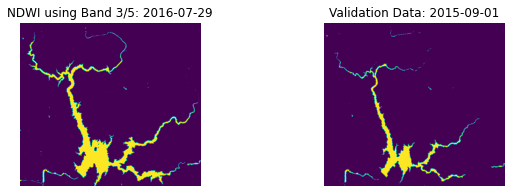

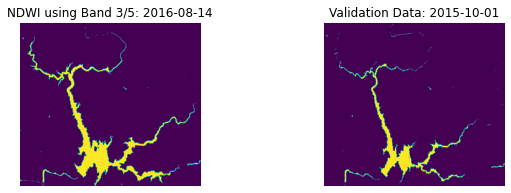

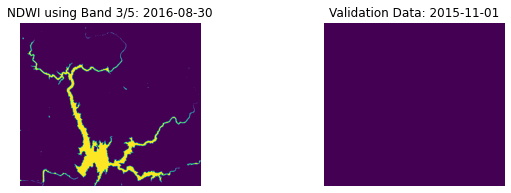

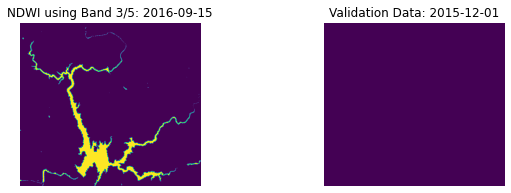

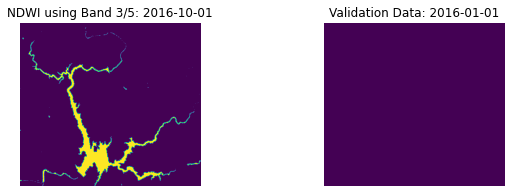

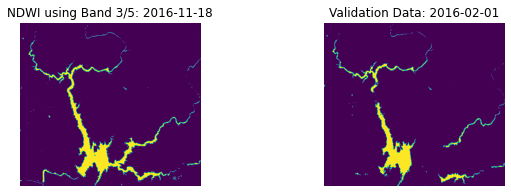

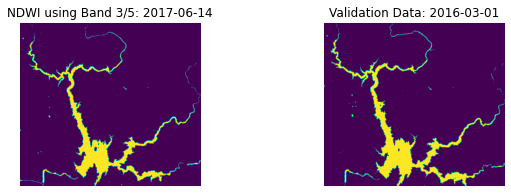

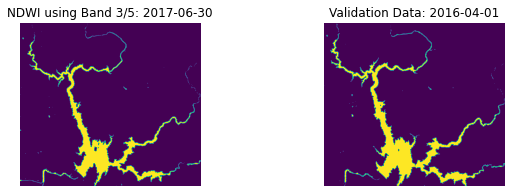

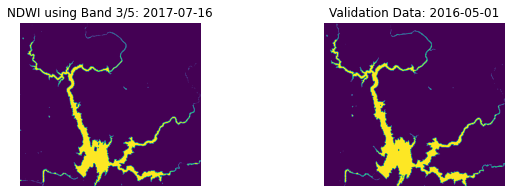

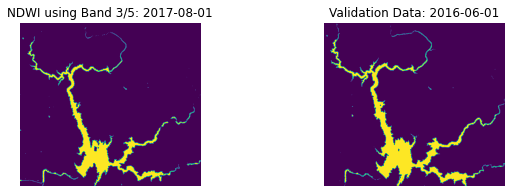

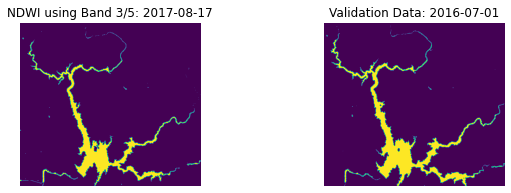

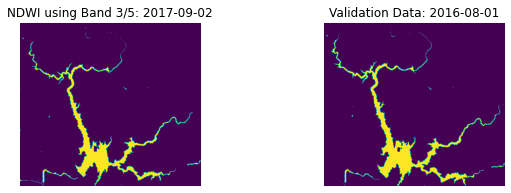

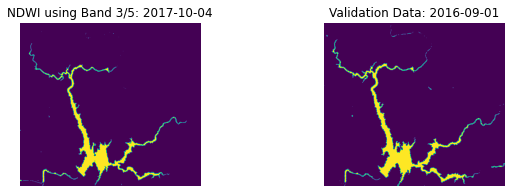

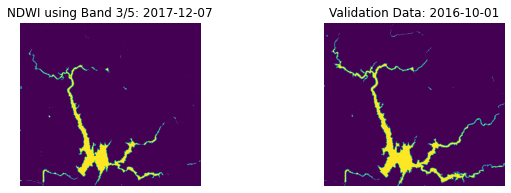

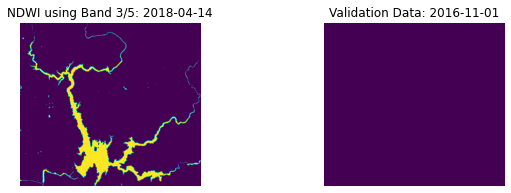

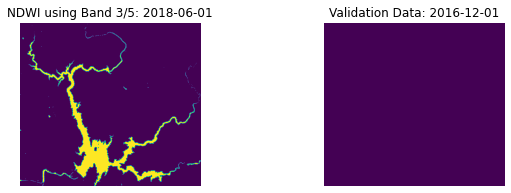

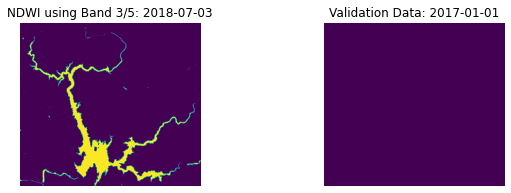

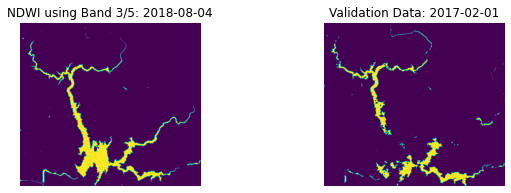

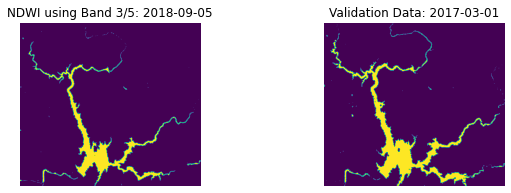

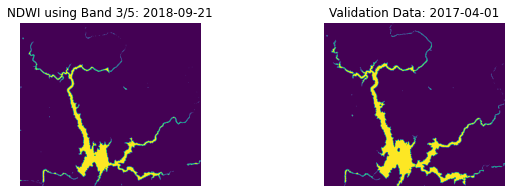

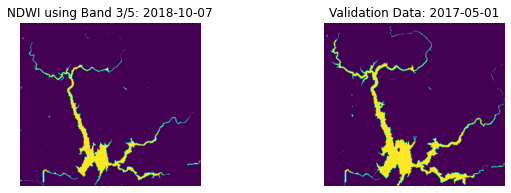

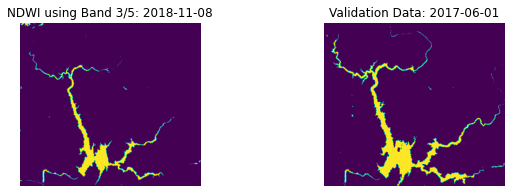

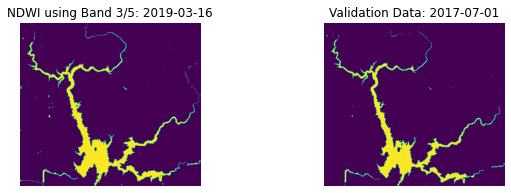

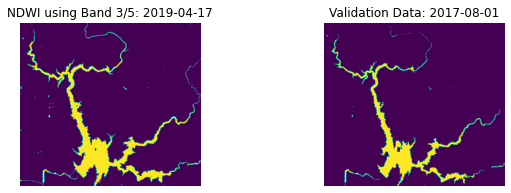

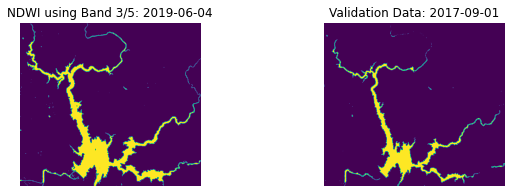

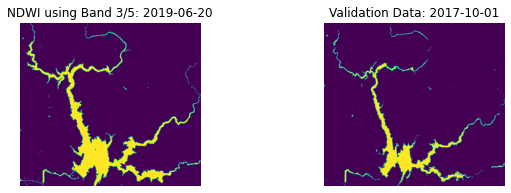

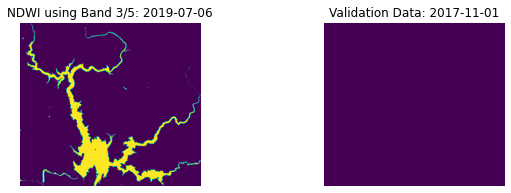

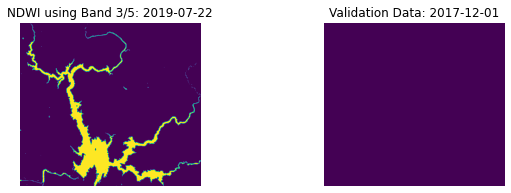

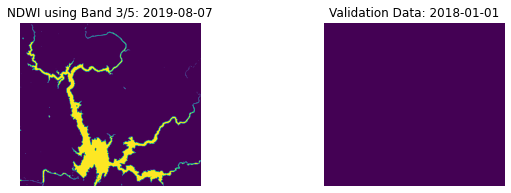

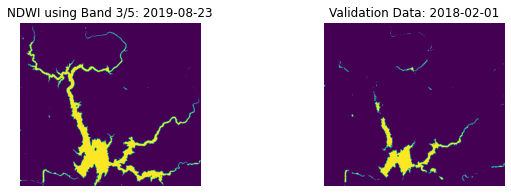

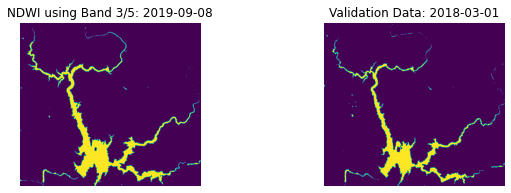

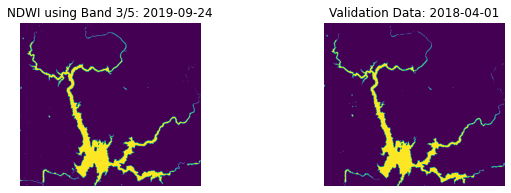

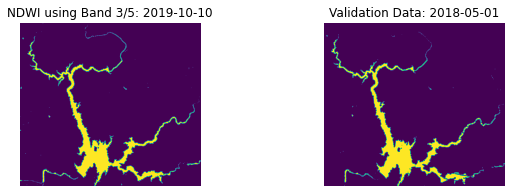

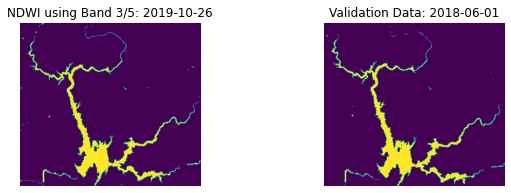

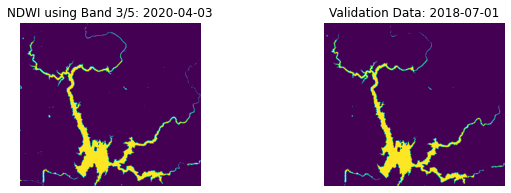

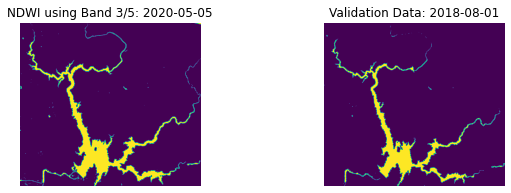

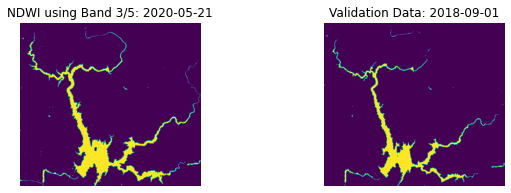

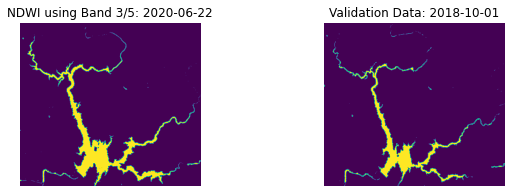

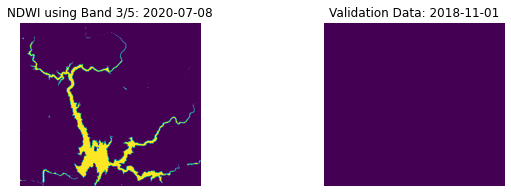

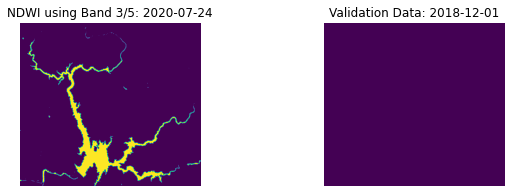

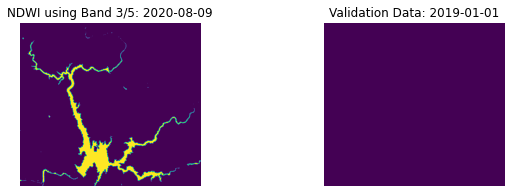

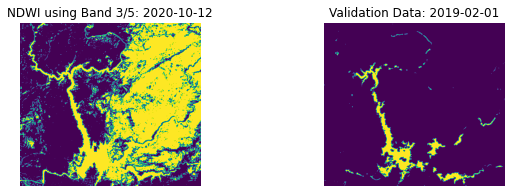

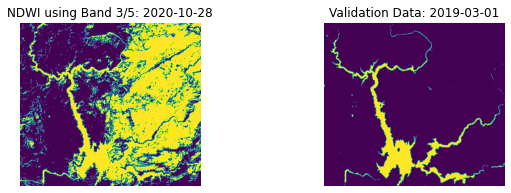

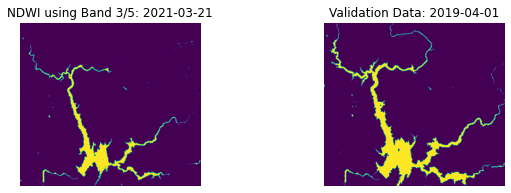

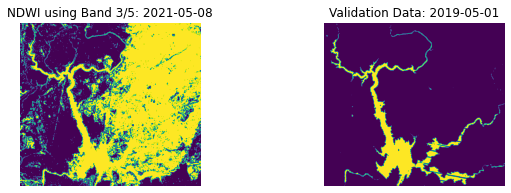

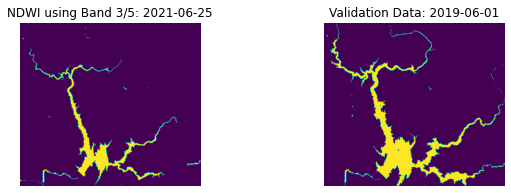

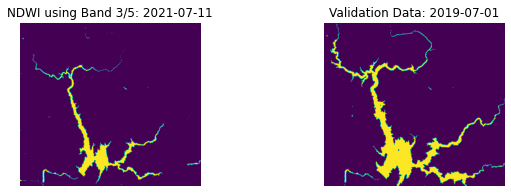

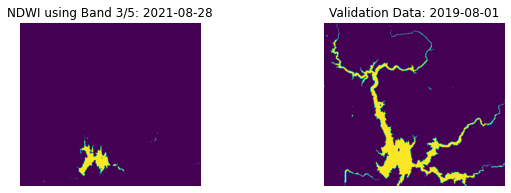

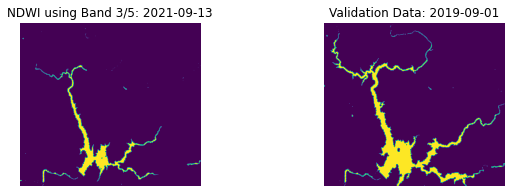

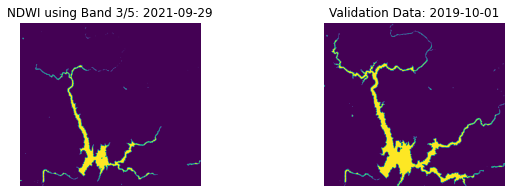

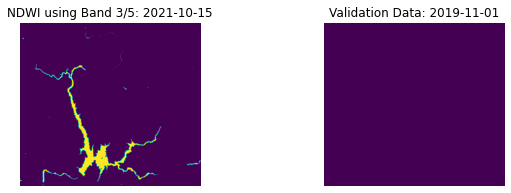

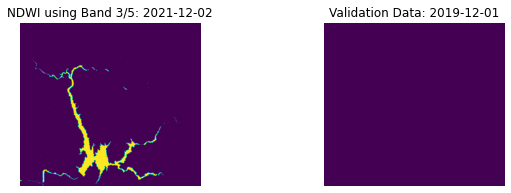

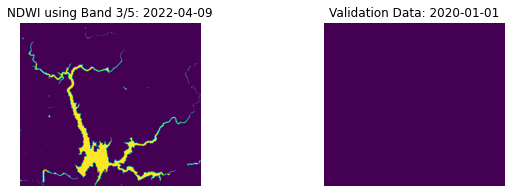

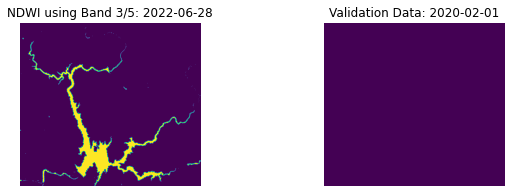

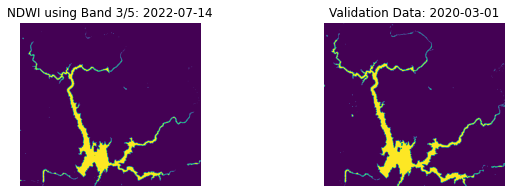

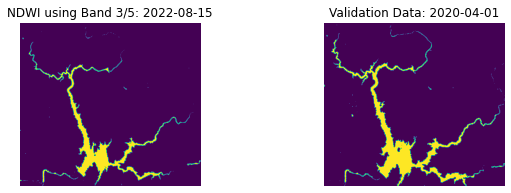

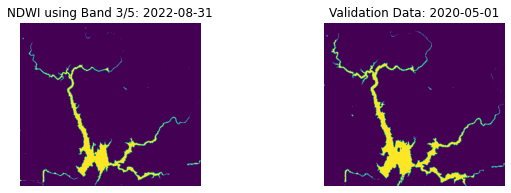

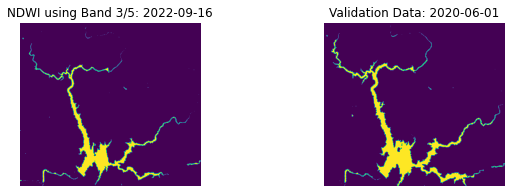

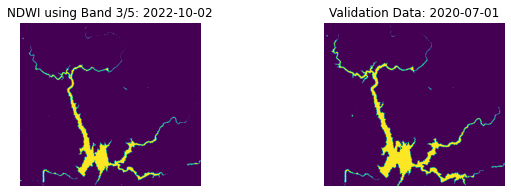

In [34]:
for i in range(len(binary_b5)):
    
    fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
    ax = axes.ravel()

    ax[0].imshow(binary_b5[i])
    ax[0].set_title('NDWI using Band 3/5: {}'.format(landsat8_ndwi_b5[i][0]))

    ax[1].imshow(resized_jrc_binary[i+2][1])
    ax[1].set_title('Validation Data: {}'.format(resized_jrc_binary[i+2][0]))


    for a in ax:
        a.axis('off')

    plt.show()

In [32]:
validation_data_area = []

for d, i in resized_jrc_binary:
    
    area = (i.flatten().sum() * (30 ** 2))
    validation_data_area.append((d, area))

#### T

In [70]:
df_b5 = pd.DataFrame(landsat8_ndwi_b5_est_area, columns=['date', 'b3_b5_est_surface_area_sq_ft'])
df_b6 = pd.DataFrame(landsat8_ndwi_b6_est_area, columns=['date', 'b3_b6_est_surface_area_sq_ft'])
df_b7 = pd.DataFrame(landsat8_ndwi_b7_est_area, columns=['date', 'b3_b7_est_surface_area_sq_ft'])
df_valid = pd.DataFrame(validation_data_area, columns=['date', 'validation_surface_area_sq_ft'])

# convert column to datetime object
df_b5['date'] = pd.to_datetime(df_b5['date'])
df_b6['date'] = pd.to_datetime(df_b6['date'])
df_b7['date'] = pd.to_datetime(df_b7['date'])
df_valid['date'] = pd.to_datetime(df_valid['date'])

# this will remove outliers from our estimates
df_b5 = df_b5[df_b5["b3_b5_est_surface_area_sq_ft"] < 1.4e8]
df_b5 = df_b5[df_b5["b3_b5_est_surface_area_sq_ft"] > 1e7]

df_b6 = df_b6[df_b6["b3_b6_est_surface_area_sq_ft"] < 1.4e8]
df_b6 = df_b6[df_b6["b3_b6_est_surface_area_sq_ft"] > 1e7]

df_b7 = df_b7[df_b7["b3_b7_est_surface_area_sq_ft"] < 1.4e8]
df_b7 = df_b7[df_b7["b3_b7_est_surface_area_sq_ft"] > 1e7]

df_valid = df_valid[df_valid["validation_surface_area_sq_ft"] > 0]

In [71]:
df_b5.reset_index().drop(columns="index")

,date,b3_b5_est_surface_area_sq_ft
0,2013-07-05,50086800
1,2013-07-21,46838700
2,2013-09-07,37703700
3,2013-09-23,36655200
4,2013-10-25,36035100
...,...,...
75,2022-07-14,35288100
76,2022-08-15,32036400
77,2022-08-31,30970800
78,2022-09-16,29728800


In [72]:
df_valid.iloc[3:].reset_index().drop(columns="index")

,date,validation_surface_area_sq_ft
0,2013-07-01,46014300
1,2013-08-01,40512600
2,2013-09-01,35901900
3,2013-10-01,36094500
4,2014-02-01,31652100
...,...,...
69,2021-06-01,29687400
70,2021-07-01,25892100
71,2021-08-01,22904100
72,2021-09-01,22652100


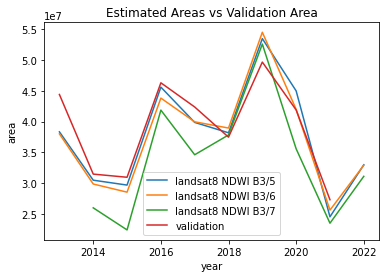

In [73]:
temp1 = df_b5.assign(year=df_b5.date.dt.year).groupby("year").mean(numeric_only=True).reset_index()
temp2 = df_valid.assign(year=df_valid.date.dt.year).groupby("year").mean(numeric_only=True).reset_index()
temp3 = df_b6.assign(year=df_b6.date.dt.year).groupby("year").mean(numeric_only=True).reset_index()
temp4 = df_b7.assign(year=df_b7.date.dt.year).groupby("year").mean(numeric_only=True).reset_index()


ax = temp1.plot(x='year', y='b3_b5_est_surface_area_sq_ft', label='landsat8 NDWI B3/5')
temp3.plot(x='year', y='b3_b6_est_surface_area_sq_ft', label='landsat8 NDWI B3/6', ax=ax)
temp4.plot(x='year', y='b3_b7_est_surface_area_sq_ft', label='landsat8 NDWI B3/7', ax=ax)
temp2.plot(x='year', y='validation_surface_area_sq_ft', label='validation', ax=ax)

plt.ylabel("area")
plt.title("Estimated Areas vs Validation Area")
plt.show()

#### Create a table with all yearly average values 

In [74]:

temp1["b3_b5_est_surface_area_sq_ft"] = temp1["b3_b5_est_surface_area_sq_ft"].map(round)
temp3["b3_b6_est_surface_area_sq_ft"] = temp3["b3_b6_est_surface_area_sq_ft"].map(round)
temp4["b3_b7_est_surface_area_sq_ft"] = temp4["b3_b7_est_surface_area_sq_ft"].map(round)
temp2["validation_surface_area_sq_ft"] = temp2["validation_surface_area_sq_ft"].map(round)


b5_b6 = temp1.merge(temp3, how="inner", on="year")
bands_merged = temp4.merge(b5_b6, how="inner", on="year")
results = bands_merged.merge(temp2, how="inner", on="year")
results

,year,b3_b7_est_surface_area_sq_ft,b3_b5_est_surface_area_sq_ft,b3_b6_est_surface_area_sq_ft,validation_surface_area_sq_ft
0,2014,25961400,30456800,29835900,31446500
1,2015,22370400,29661900,28510500,30932600
2,2016,41852250,45592700,43806300,46293800
3,2017,34592100,39852338,39948043,42361100
4,2018,37810200,38164838,38937729,37455600
5,2019,52591950,53481375,54515300,49664400
6,2020,35561700,44975443,41972914,41877450
7,2021,23462486,24501343,25591275,27277875
